In [1]:
using SparseArrays
using LinearAlgebra
using NLopt
using KrylovKit
using Statistics
using FiniteDifferences
using Revise
using TopologyOptimizationHelper

In [2]:
using PyPlot
using DelimitedFiles

In [3]:
function log_LDOS_Optimize(L, ε, ω, b; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, design_width=L, fixed_width=0)
    A, x = Maxwell1d(L, ε, ω; dpml, resolution, Rpml)
    D² = A + spdiagm(ω^2 .* ε)
    M = length(x)
    log_LDOS_vals = Float64[]
    log_omegas = ComplexF64[]
    iter = 1
    
    function log_LDOS_obj(ε, grad)
        A = D² - spdiagm(ω^2 .* ε)
        LDOS, ∇LDOS = ∇_ε_LDOS(A, ω, b)
        log_LDOS = log(LDOS)
        grad .= ∇LDOS / LDOS
        push!(log_LDOS_vals, log_LDOS)

        A_now, _ = Maxwell1d(L, ε, ω; resolution, dpml, Rpml)
        ω₀_now = sqrt(Arnoldi_eig(A_now, ε, ω, b)[1])
        push!(log_omegas, ω₀_now)

        if iter % 1000 == 0
            @show iter, LDOS
        end

        iter += 1
        
        return log_LDOS
    end

    design_indices = (-design_width/2 .< x .- mean(x) .< design_width/2) .& .!(-fixed_width/2 .< x .- mean(x) .< fixed_width/2)
    ub = copy(ε)
    lb = copy(ε)
    ub[design_indices] .= 12
    lb[design_indices] .= 1
    opt = Opt(:LD_CCSAQ, M)
    opt.lower_bounds = lb
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.maxeval = max_eval
    opt.max_objective = log_LDOS_obj

    (log_LDOS_opt, log_ε_opt, ret) = optimize(opt, ε)
    A_opt, _ = Maxwell1d(L, log_ε_opt, ω; resolution, dpml, Rpml)
    ω₀_opt = sqrt(Arnoldi_eig(A_opt, log_ε_opt, ω, b)[1])
    Q_opt = -real(ω₀_opt) / 2imag(ω₀_opt)

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀_opt
    @show Q_opt
    
    return log_LDOS_opt, log_ε_opt, log_LDOS_vals, log_omegas, x
end

log_LDOS_Optimize (generic function with 1 method)

In [4]:
function grad_LDOS(L, ε, ω, b; resolution=20)
    A, _ = Maxwell1d(L, ε, ω; resolution)
    v = A \ vec(b)
    w = conj.(v)
    return -ω^2 * imag.(w.^2) / (-imag(v' * b))
end

grad_LDOS (generic function with 1 method)

In [5]:
function Hess_LDOS(L, ε, ω, b; resolution=20)
    n = length(ε)
    Jac = []
    free_idx = findall(x -> x != 1 && x != 12, ε)

    for j in free_idx
        e_j = zeros(n)
        e_j[j] = 1

        f = h -> grad_LDOS(L, ε + h * e_j, ω, b; resolution)
        grad_dir = extrapolate_fdm(central_fdm(10, 1), f, 0)[1]
        push!(Jac, grad_dir[free_idx])
    end

    return hcat(Jac...)
end

Hess_LDOS (generic function with 1 method)

In [6]:
L = 5
res = 50
ε = ones(res * (L + 1))
M = length(ε) 
ω = 2π
_, x = Maxwell1d(L, ε, ω; resolution=res)

b = zeros(M)
b[M÷2] = 1;

In [7]:
rc("font", family="serif", serif="Times New Roman")
rc("mathtext", fontset="cm")
rc("xtick", labelsize=11.5)  # x-axis tick labels
rc("ytick", labelsize=12)  # y-axis tick labels

In [8]:
_, ε_1, _, _, _ = log_LDOS_Optimize(L, ε, ω, b; resolution=res, ftol=0, max_eval=50)

numevals = opt.numevals = 50
ω₀_opt = 6.2832645234430675 - 0.013047084443869641im
Q_opt = 240.79190069147398


(-2.141500345912838, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-6.444372124966526, -7.081880244654986, -7.3060229231399925, -5.921458317616547, -5.482508141667833, -6.082537612669413, -5.285758172895155, -4.651187884583259, -7.574577028584068, -6.716796904117968  …  -3.0908739824366642, -2.3695332731930785, -5.526664975188313, -2.3359559594808967, -8.580268997287396, -7.800088937690603, -5.846611244417182, -3.298280477371547, -2.153059031751468, -2.141500345912838], ComplexF64[5.764179529542722 - 2.1834196863707422im, 6.2624622718047585 - 0.09931763879737113im, 6.646046896754592 - 0.19581487275866052im, 6.049571006399429 - 0.2616991178839609im, 6.328108399517975 - 0.27778080499412455im, 6.015745993884492 - 0.1519588985820529im, 6.226479568999578 - 0.22905095543480053im, 6.212494990962934 - 0.10162142325377621im, 6.491259081525111 - 0.02712576468900181im, 6.585969731472339 - 0.1235040014351292im  …  6.267674658801449 - 0.00

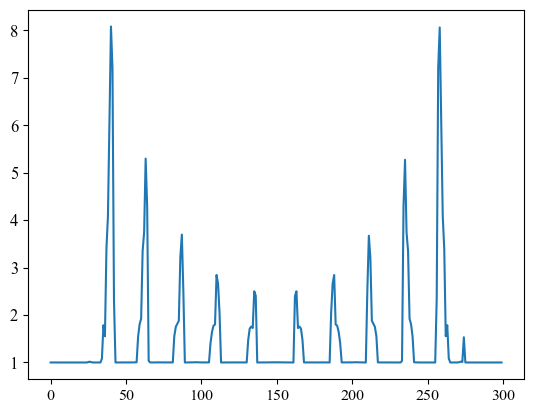

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001B24D7ED2D0>

In [9]:
plot(ε_1)

In [10]:
ω₁ = 6.2832645234430675 - 0.013047084443869641im
Hess1 = Hess_LDOS(L, ε_1, real(ω₁), b; resolution=res)
SVD1 = svdvals(Hess1)
@show m1 = maximum(SVD1)
Q1 = -real(ω₁) / 2imag(ω₁)

m1 = maximum(SVD1) = 985.767370651059


240.79190069147398

In [11]:
_, ε_2, _, _, _ = log_LDOS_Optimize(L, ε, ω, b; resolution=res, ftol=0, max_eval=99)

numevals = opt.numevals = 99
ω₀_opt = 6.283116817495574 - 0.003034930554878199im
Q_opt = 1035.1335399415318


(-0.6218765523379141, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-6.444372124966526, -7.081880244654986, -7.3060229231399925, -5.921458317616547, -5.482508141667833, -6.082537612669413, -5.285758172895155, -4.651187884583259, -7.574577028584068, -6.716796904117968  …  -0.7009536765624198, -0.6992638245958286, -0.6944978767231406, -0.653363066065667, -8.15935625339042, -6.0113497628324035, -2.5564864411312973, -0.6617890864802222, -0.6400989613664934, -0.6218765523379141], ComplexF64[5.764179529542722 - 2.1834196863707422im, 6.2624622718047585 - 0.09931763879737113im, 6.646046896754592 - 0.19581487275866052im, 6.049571006399429 - 0.2616991178839609im, 6.328108399517975 - 0.27778080499412455im, 6.015745993884492 - 0.1519588985820529im, 6.226479568999578 - 0.22905095543480053im, 6.212494990962934 - 0.10162142325377621im, 6.491259081525111 - 0.02712576468900181im, 6.585969731472339 - 0.1235040014351292im  …  6.2830518367802775 

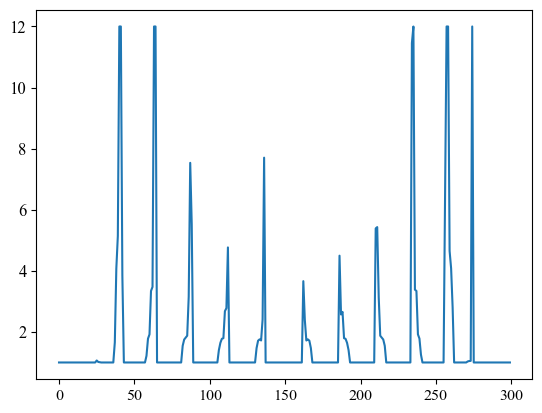

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001B266F1A500>

In [12]:
plot(ε_2)

In [13]:
ω₂ = 6.283116817495574 - 0.003034930554878199im
Hess2 = Hess_LDOS(L, ε_2, real(ω₂), b; resolution=res)
SVD2 = svdvals(Hess2)
@show m2 = maximum(SVD2)
Q2 = -real(ω₂) / 2imag(ω₂)

m2 = maximum(SVD2) = 19020.160105293897


1035.1335399415318

In [14]:
_, ε_3, _, _, _ = log_LDOS_Optimize(L, ε, ω, b; resolution=res, ftol=0, max_eval=150)

numevals = opt.numevals = 150
ω₀_opt = 6.283196371934735 - 0.0007010720314785358im
Q_opt = 4481.134669346101


(0.8765661967318431, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-6.444372124966526, -7.081880244654986, -7.3060229231399925, -5.921458317616547, -5.482508141667833, -6.082537612669413, -5.285758172895155, -4.651187884583259, -7.574577028584068, -6.716796904117968  …  0.512931073883061, 0.7244926181595257, 0.6451378990580524, 0.7492494954297317, 0.7976766384753742, -0.4381449129535791, 0.8268069658996057, 0.8487046866092506, 0.8381070183102972, 0.8765661967318431], ComplexF64[5.764179529542722 - 2.1834196863707422im, 6.2624622718047585 - 0.09931763879737113im, 6.646046896754592 - 0.19581487275866052im, 6.049571006399429 - 0.2616991178839609im, 6.328108399517975 - 0.27778080499412455im, 6.015745993884492 - 0.1519588985820529im, 6.226479568999578 - 0.22905095543480053im, 6.212494990962934 - 0.10162142325377621im, 6.491259081525111 - 0.02712576468900181im, 6.585969731472339 - 0.1235040014351292im  …  6.283638050965184 - 0.00072

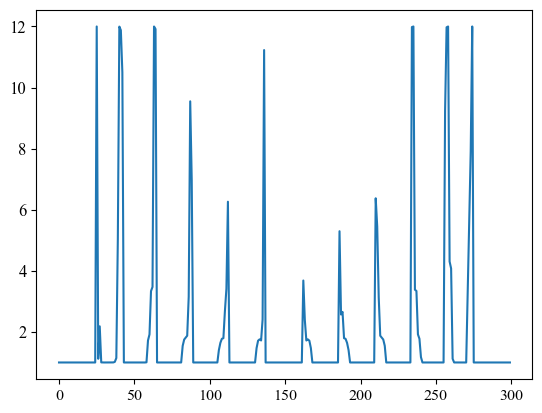

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001B252E405E0>

In [15]:
plot(ε_3)

In [16]:
ω₃ = 6.283196371934735 - 0.0007010720314785358im
Hess3 = Hess_LDOS(L, ε_3, real(ω₃), b; resolution=res)
SVD3 = svdvals(Hess3)
@show m3 = maximum(SVD3)
Q3 = -real(ω₃) / 2imag(ω₃)

m3 = maximum(SVD3) = 376327.2177343406


4481.134669346101

In [17]:
_, ε_4, _, _, _ = log_LDOS_Optimize(L, ε, ω, b; resolution=res, ftol=0, max_eval=200)

numevals = opt.numevals = 200
ω₀_opt = 6.283189483633811 - 0.00029804921326253615im
Q_opt = 10540.523517670343


(1.7334239622170895, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-6.444372124966526, -7.081880244654986, -7.3060229231399925, -5.921458317616547, -5.482508141667833, -6.082537612669413, -5.285758172895155, -4.651187884583259, -7.574577028584068, -6.716796904117968  …  1.7185413390575763, 1.5283261281217042, 1.7220000059117198, 1.7300611558533363, 1.461376327977108, 1.7161504826753693, 1.731808959724245, 0.8052594516411131, 1.7252610273371929, 1.7334239622170895], ComplexF64[5.764179529542722 - 2.1834196863707422im, 6.2624622718047585 - 0.09931763879737113im, 6.646046896754592 - 0.19581487275866052im, 6.049571006399429 - 0.2616991178839609im, 6.328108399517975 - 0.27778080499412455im, 6.015745993884492 - 0.1519588985820529im, 6.226479568999578 - 0.22905095543480053im, 6.212494990962934 - 0.10162142325377621im, 6.491259081525111 - 0.02712576468900181im, 6.585969731472339 - 0.1235040014351292im  …  6.28320446270086 - 0.00030125

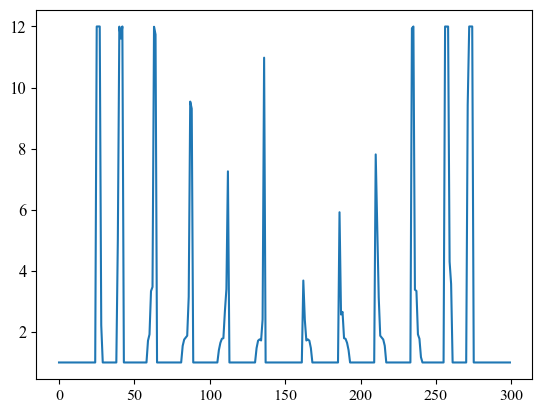

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001B252EA1960>

In [18]:
plot(ε_4)

In [19]:
ω₄ = 6.283189483633811 - 0.00029804921326253615im
Hess4 = Hess_LDOS(L, ε_4, real(ω₄), b; resolution=res)
SVD4 = svdvals(Hess4)
@show m4 = maximum(SVD4)
Q4 = -real(ω₄) / 2imag(ω₄)

m4 = maximum(SVD4) = 2.088103617661705e6


10540.523517670343

In [20]:
@show ms = [m1, m2, m3, m4]
Qs = [Q1, Q2, Q3, Q4]

ms = [m1, m2, m3, m4] = [985.767370651059, 19020.160105293897, 376327.2177343406, 2.088103617661705e6]


4-element Vector{Float64}:
   240.79190069147398
  1035.1335399415318
  4481.134669346101
 10540.523517670343

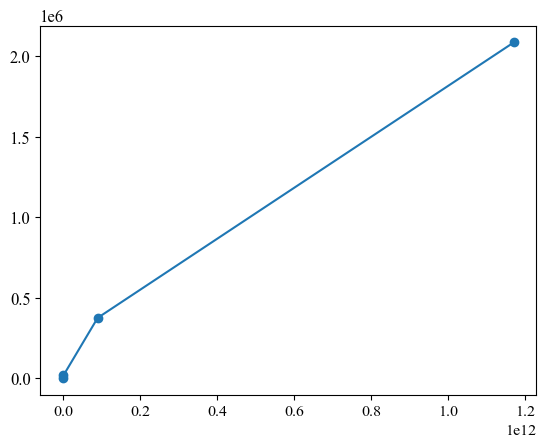

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001B252F0BA30>

In [21]:
plot(Qs.^3, ms, "o-")

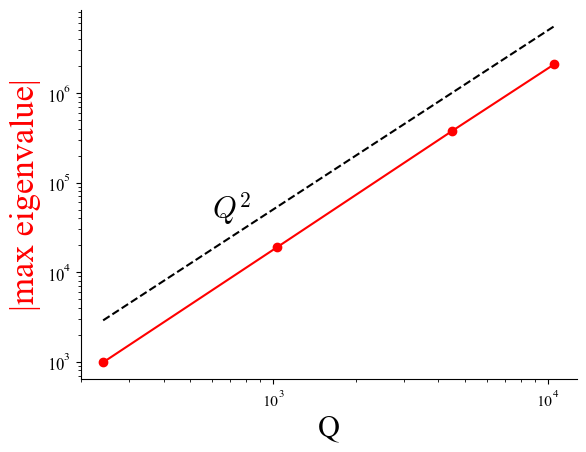

In [31]:
loglog(Qs, ms, "o-", color="red")
loglog(Qs, 0.05Qs.^2, "--", color="black")
text(600, 40000, L"$Q^2$", color="black", fontsize=22)
xlabel("Q", fontsize=22)
ylabel("|max eigenvalue|", color="red", fontsize=25)
gca().spines["top"].set_visible(false)
gca().spines["right"].set_visible(false)

savefig("scales_like_Q3.pdf", bbox_inches="tight", pad_inches=0)
savefig("scales_like_Q3.svg", bbox_inches="tight", pad_inches=0)